# Breast Cancer Prediction

The objective of this project is to predict the cancer of a patient given the digitized image of a fine needle aspirate (FNA) of a breast mass. 
The features describe characteristics of the cell nuclei present in the image. In brief, 10 real-valued features are computed for each cell nucleus (radius, texture, perimeter, area...). Given this we want to **predict the malignantness for a patient**. 

In this dataset the class distribution is: 357 benign and 212 malignant.


The data used comes from K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34 (see Kaggle repository: [https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)).


In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import torch
import random 
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.neighbors import  KNeighborsClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import GridSearchCV

In [172]:
SEED = 42
np.random.seed(SEED) 
random.seed(SEED)
torch.manual_seed(SEED)
tf.random.set_seed(SEED)

In [173]:
# Download the dataset
url = 'https://www.kaggle.com/api/v1/datasets/download/uciml/breast-cancer-wisconsin-data/'
data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1", compression='zip')

In [174]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# 1. Exploratory Data Analysis

## 1.1. Resume

### 1.1.1. Form Analysis:
- **target variable** : diagnosis (M or B)
- **row and columns** : 569, 32
- **variable types** : qualitatives : 30, quantitatives : 1
- **missing value analysis** :
    - No NaN, except the last column 'Unnamed: 32' (removing possible)

### 1.1.2. Background Analysis:
- **target visualization** :
    - 37% of malign (212 / 569)
    
    
    
- **variable significance** :
    - raw data: variables present no normalization or standardization
    - variables relative to cell size (radius, perimeter, area) seems having two groups of values. Need to explore this in details.
    



    

## 1.2. Form analysis


In [175]:
df = data.copy()

In [176]:
df.shape

(569, 32)

In [177]:
df.dtypes.value_counts()

float64    31
object      1
Name: count, dtype: int64

<Axes: ylabel='id'>

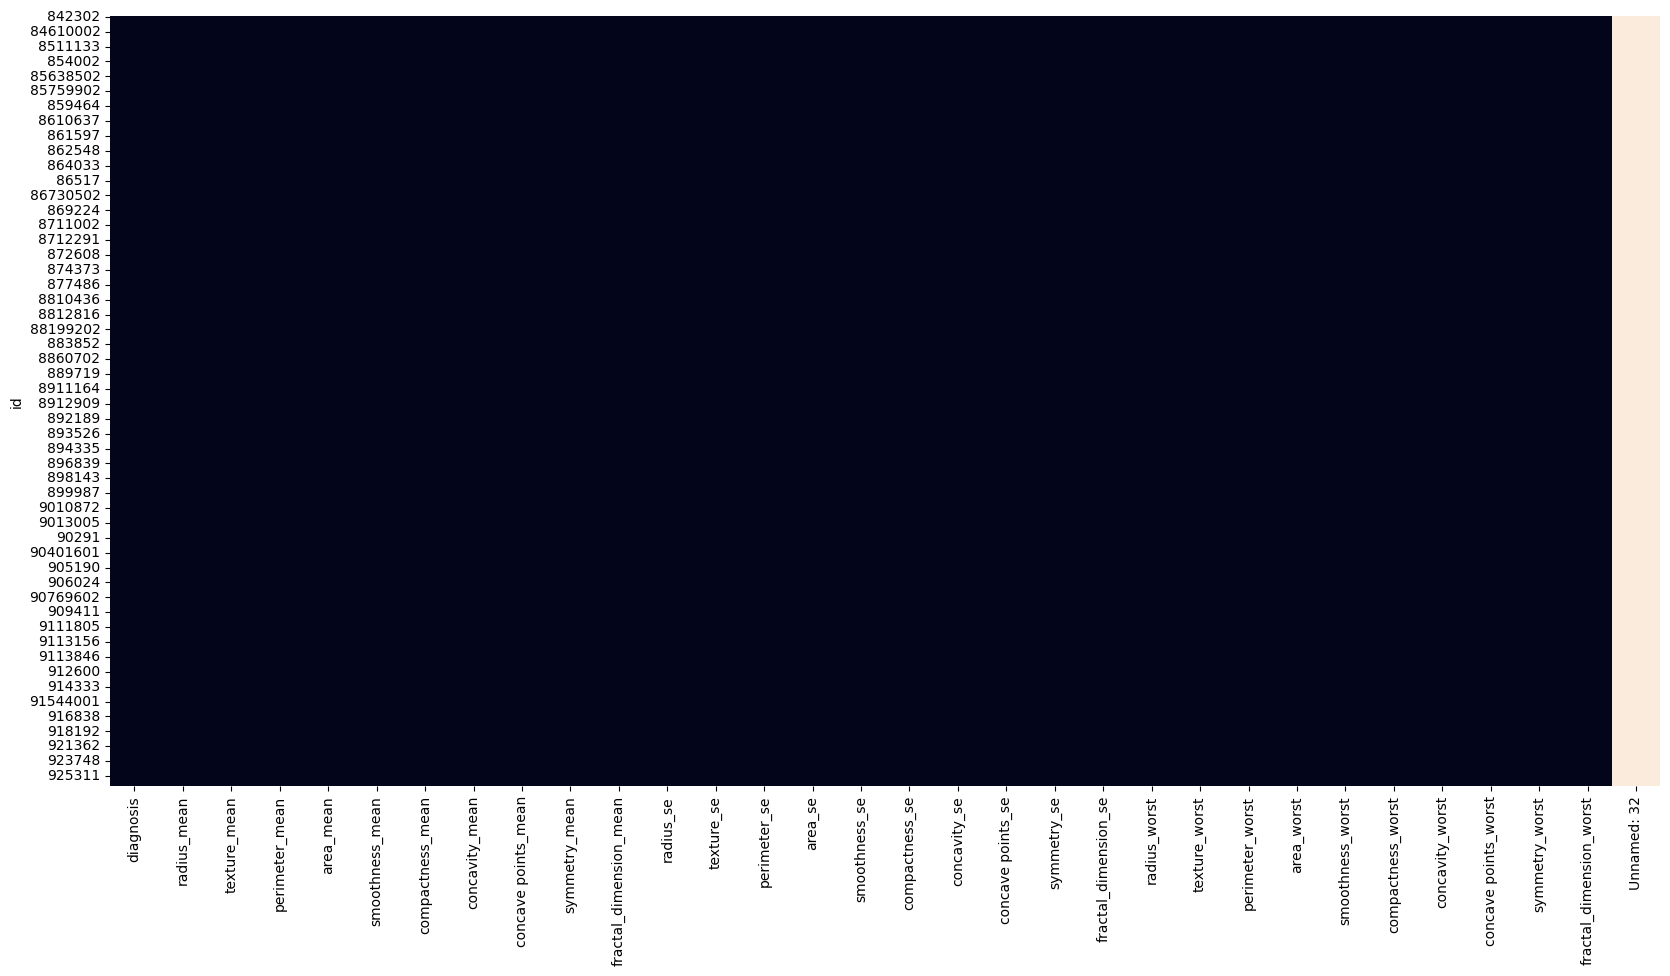

In [178]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [179]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Unnamed: 32                1.0
diagnosis                  0.0
texture_mean               0.0
radius_mean                0.0
area_mean                  0.0
smoothness_mean            0.0
compactness_mean           0.0
perimeter_mean             0.0
concave points_mean        0.0
symmetry_mean              0.0
fractal_dimension_mean     0.0
radius_se                  0.0
texture_se                 0.0
perimeter_se               0.0
area_se                    0.0
concavity_mean             0.0
smoothness_se              0.0
compactness_se             0.0
concave points_se          0.0
concavity_se               0.0
fractal_dimension_se       0.0
radius_worst               0.0
texture_worst              0.0
symmetry_se                0.0
perimeter_worst            0.0
area_worst                 0.0
compactness_worst          0.0
smoothness_worst           0.0
concavity_worst            0.0
concave points_worst       0.0
symmetry_worst             0.0
fractal_dimension_worst    0.0
dtype: f

## 1.3. Background Analysis
### 1.3.1. Initial visualization

In [180]:
# removing the 'Unnamed: 32' columns which it is an error
df = df.drop('Unnamed: 32', axis=1)

In [181]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 1.3.2. Target examination



In [182]:
print(df['diagnosis'].value_counts())

df['diagnosis'].value_counts(normalize=True)

diagnosis
B    357
M    212
Name: count, dtype: int64


diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64

### 1.3.3. Variable histograms




/tmp/ipykernel_440793/285106243.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 2, 1]})


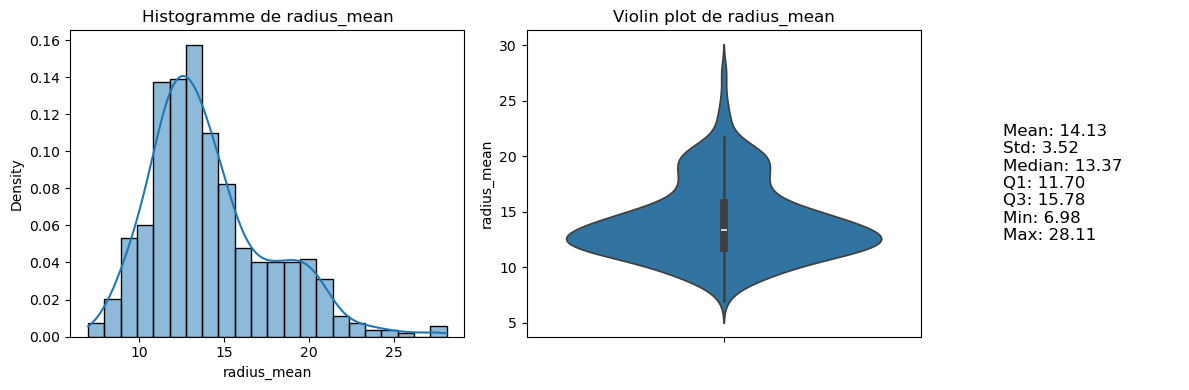

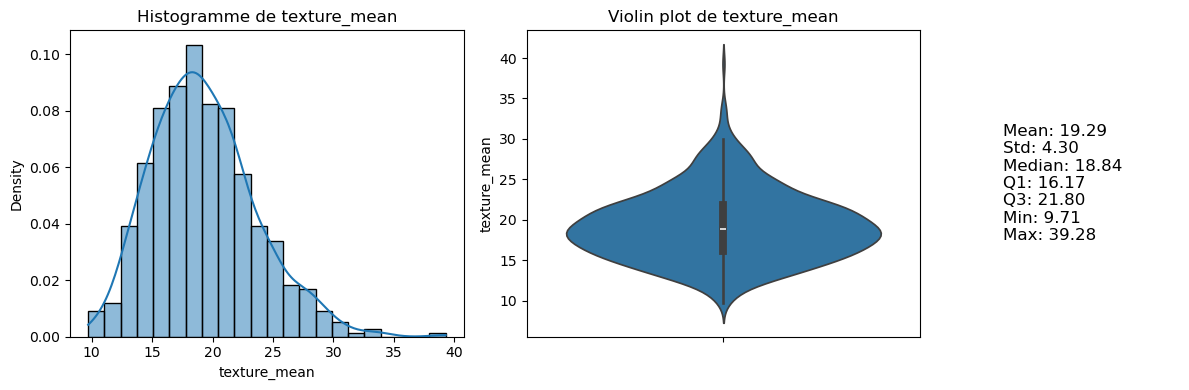

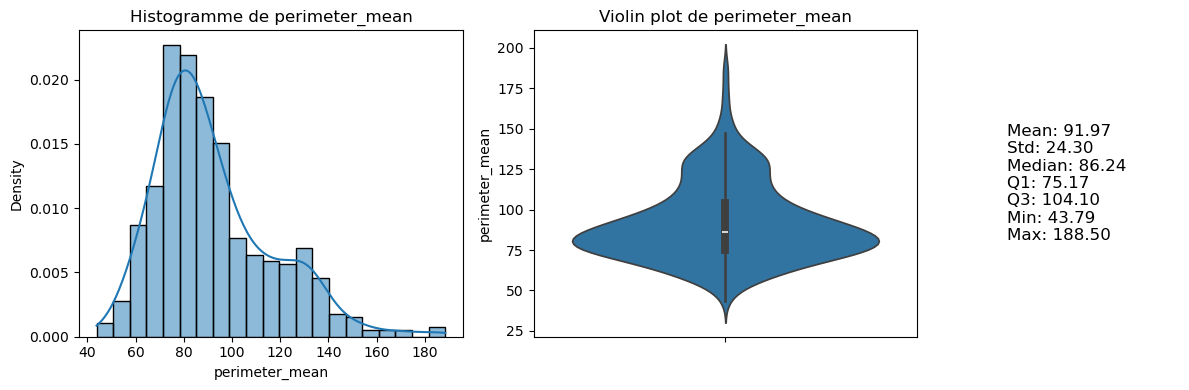

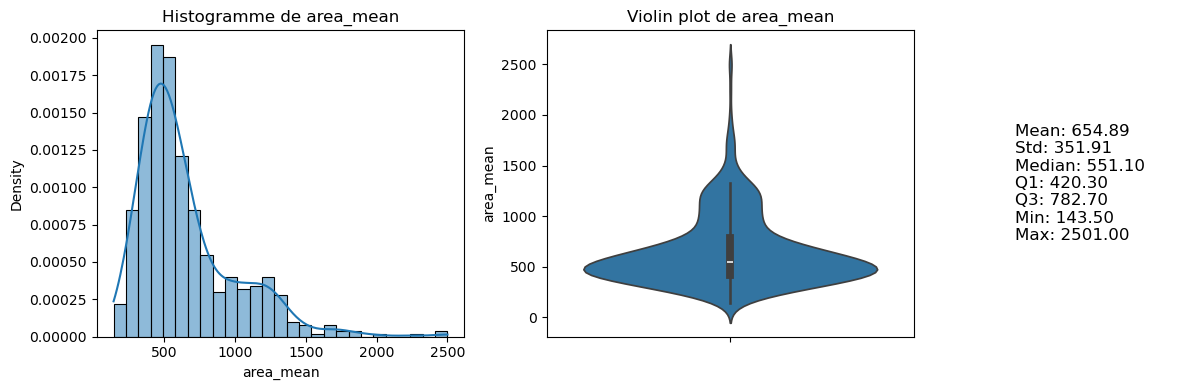

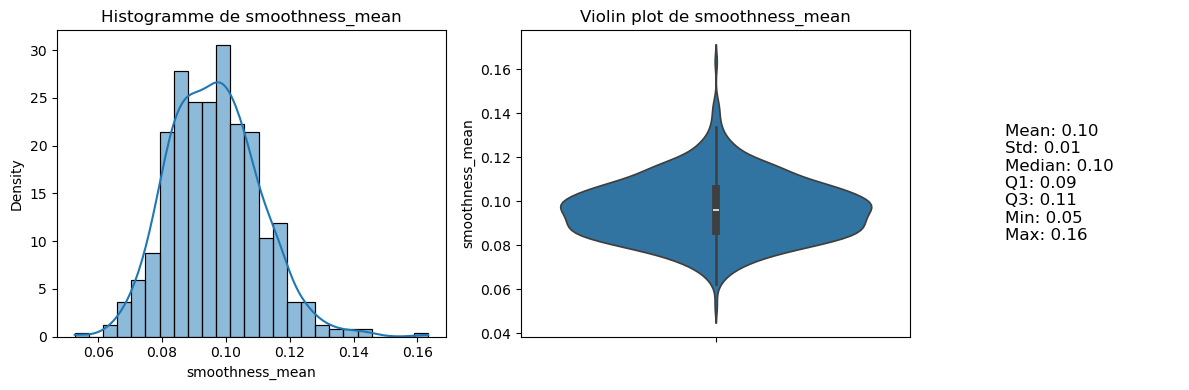

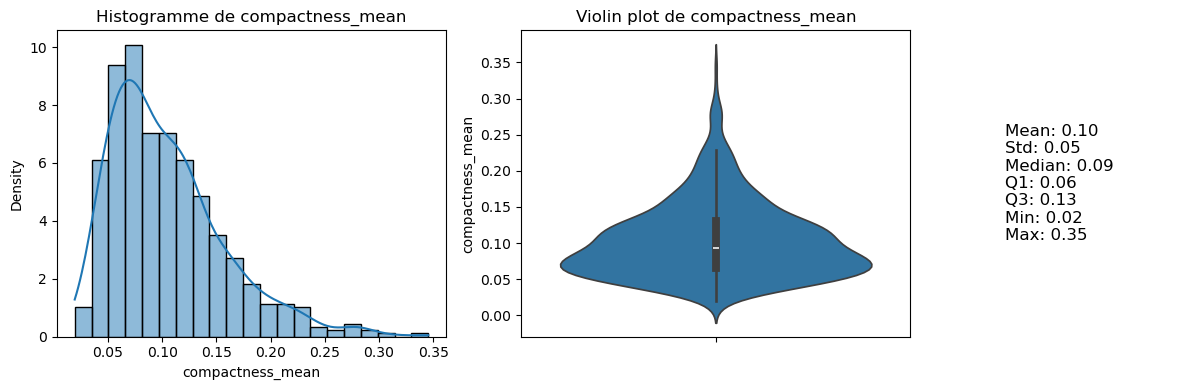

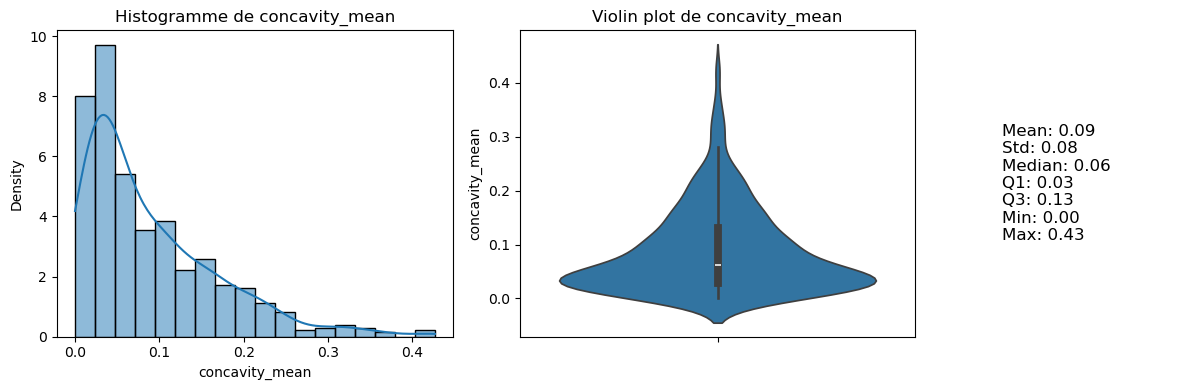

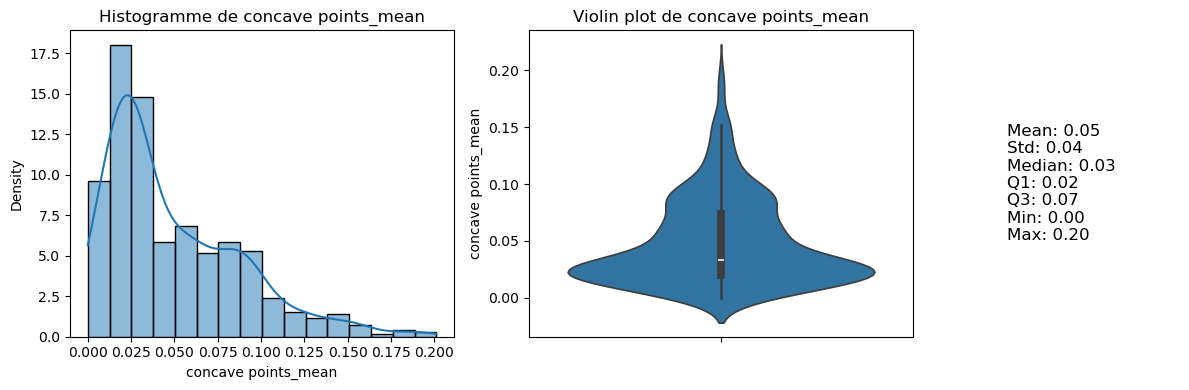

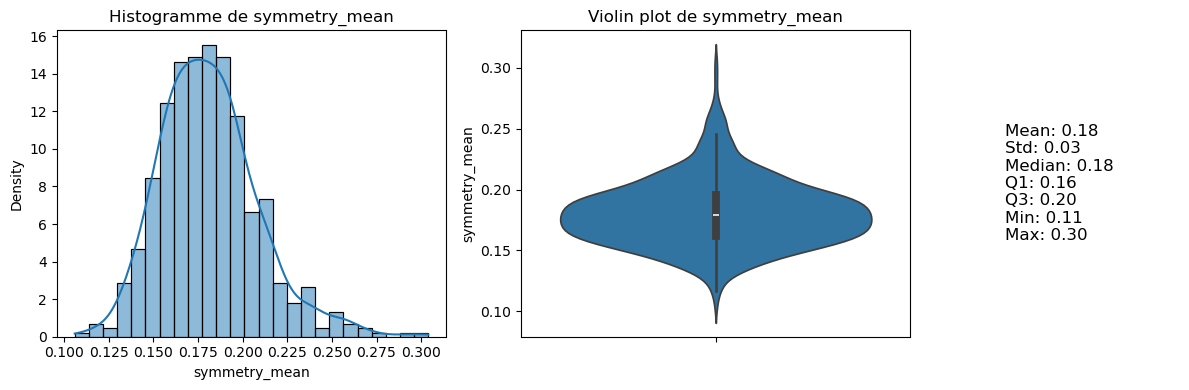

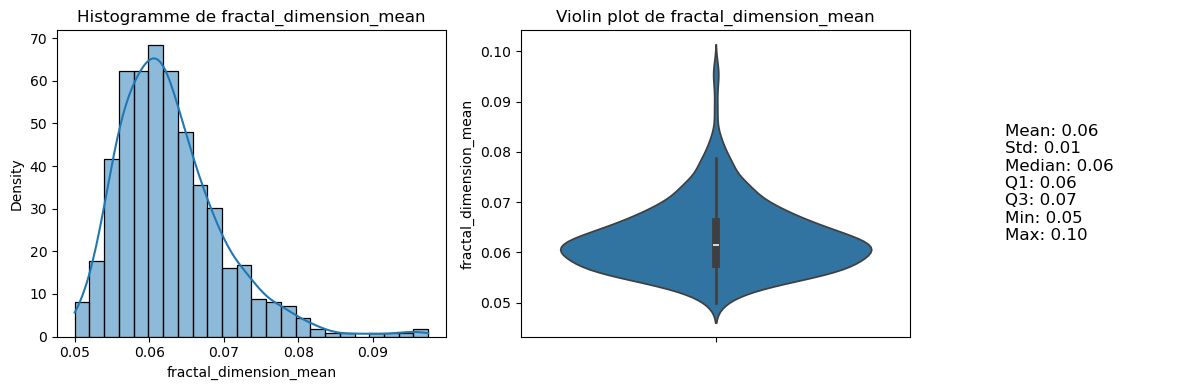

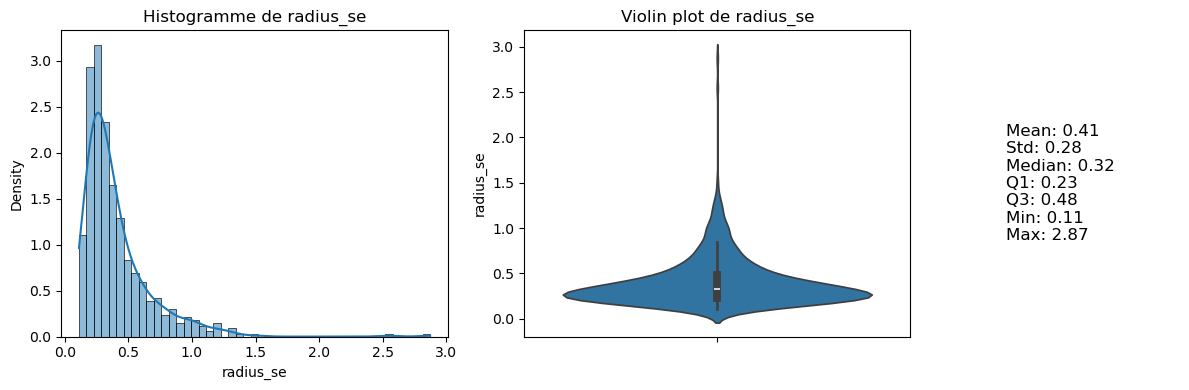

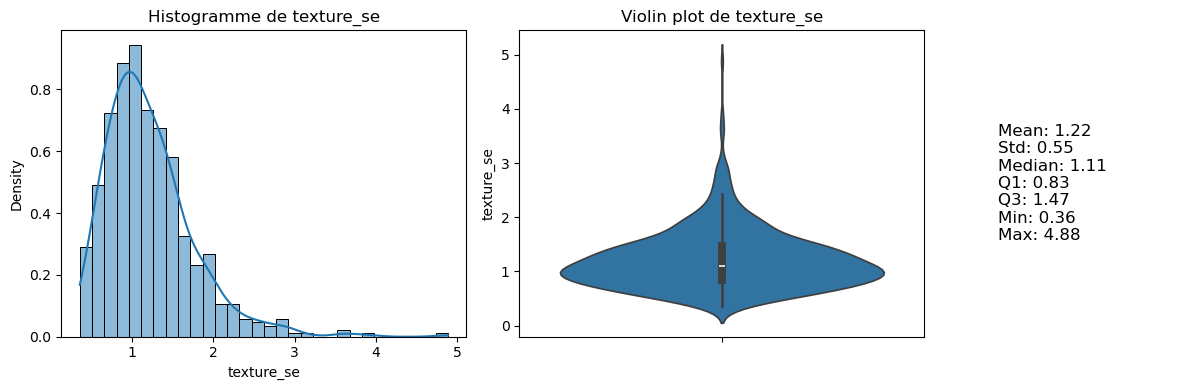

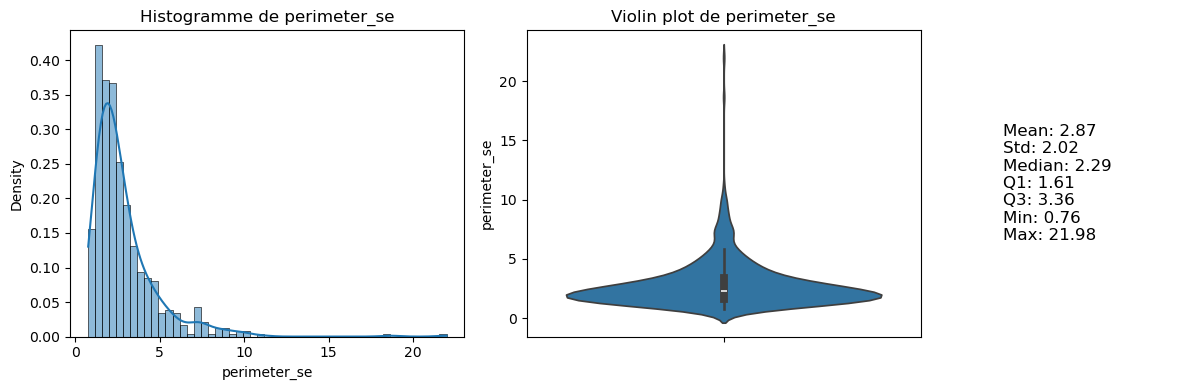

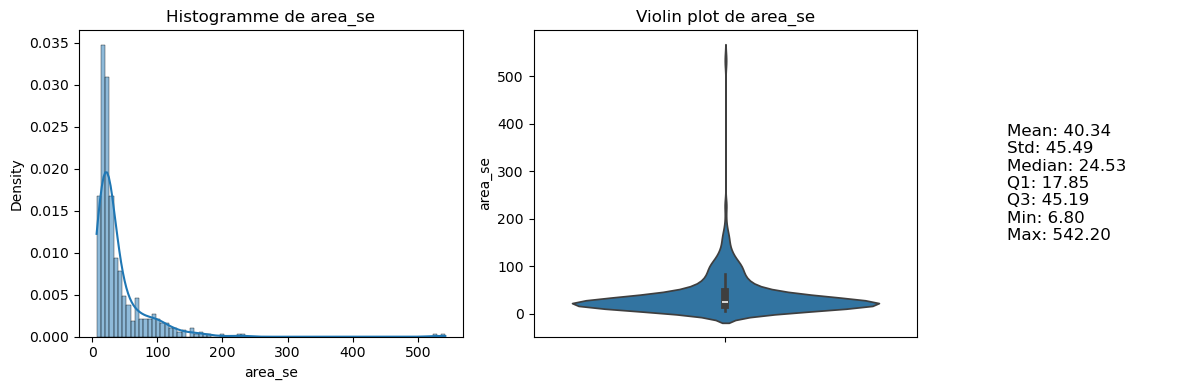

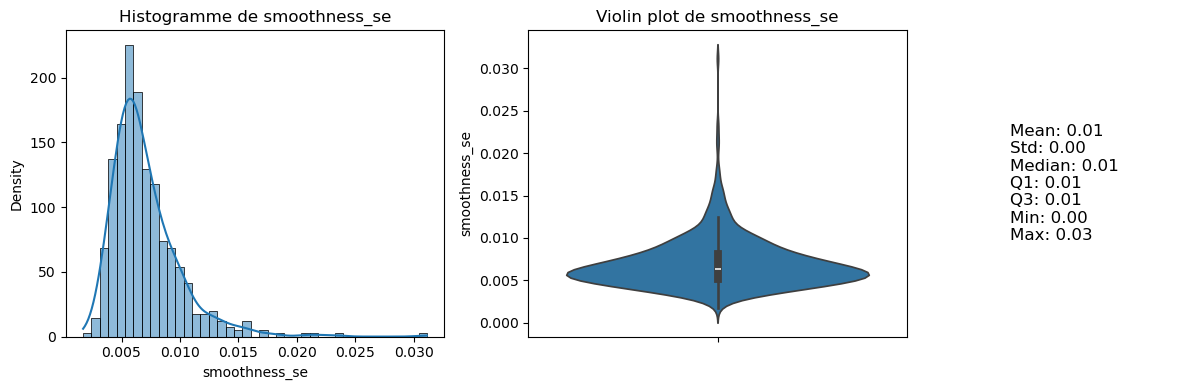

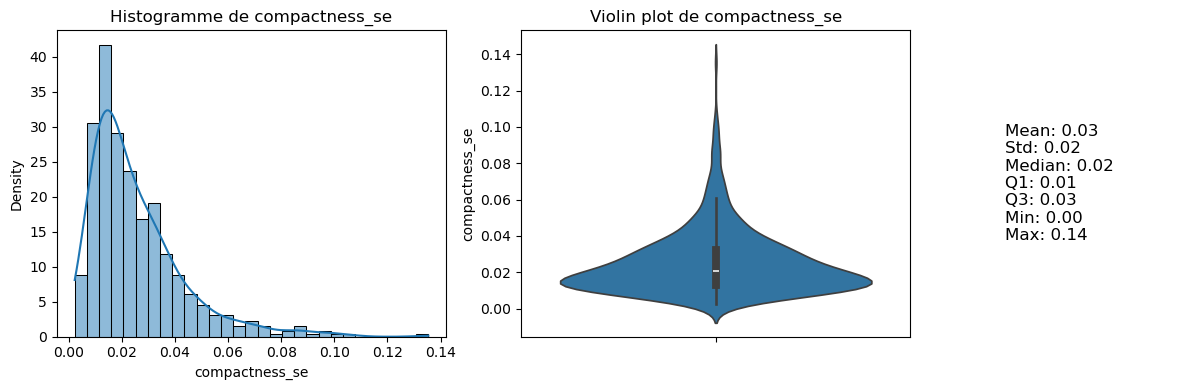

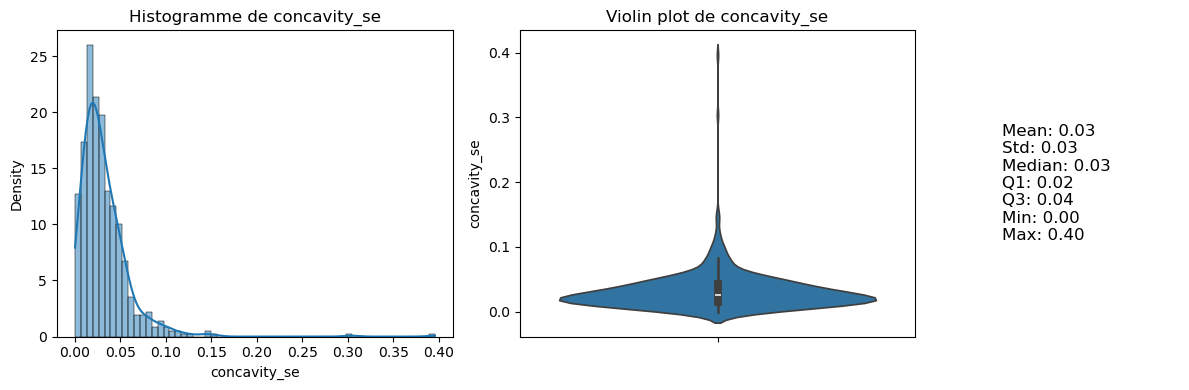

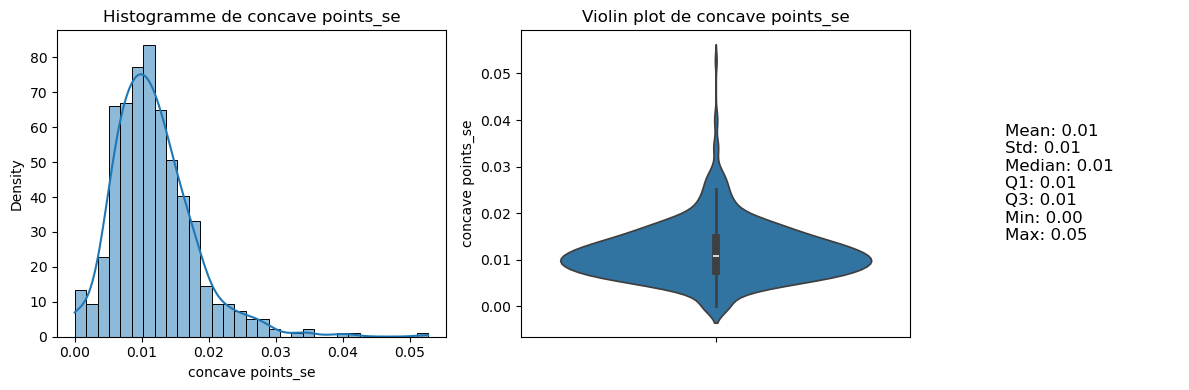

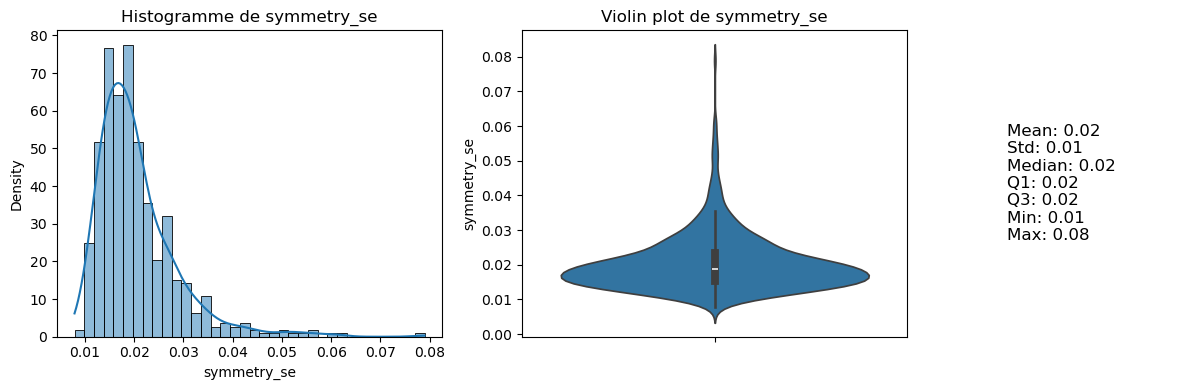

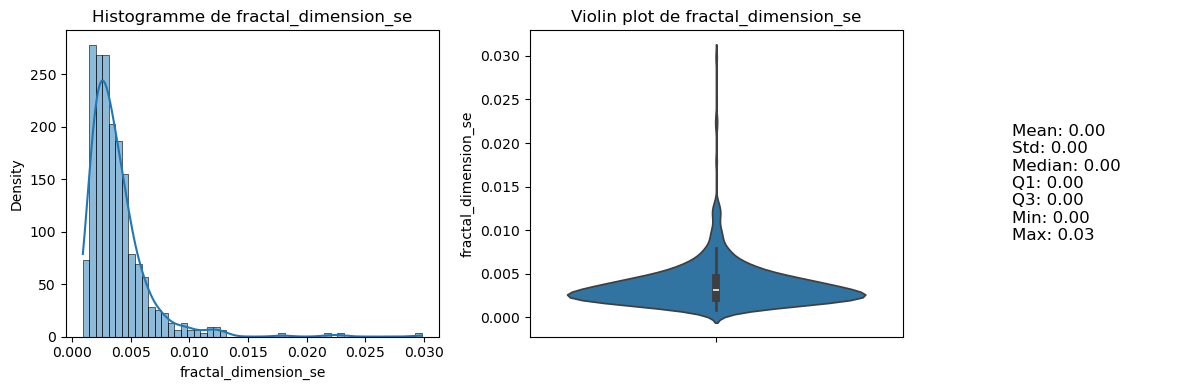

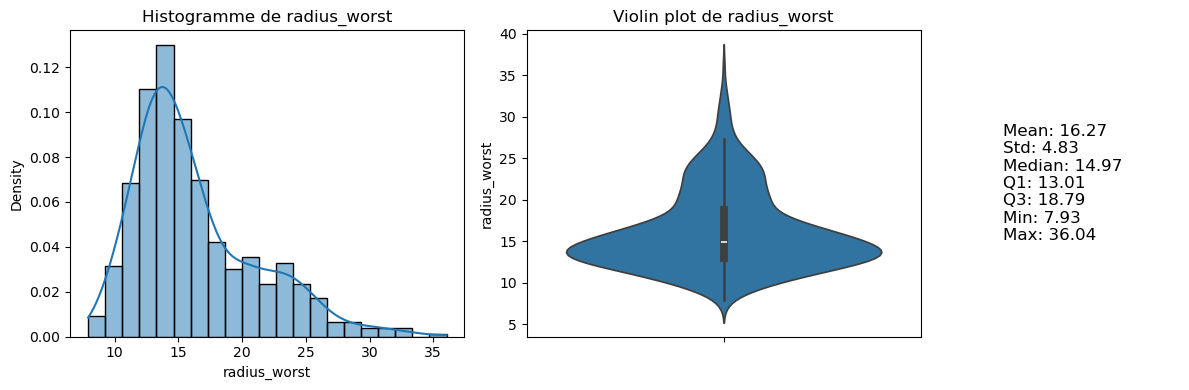

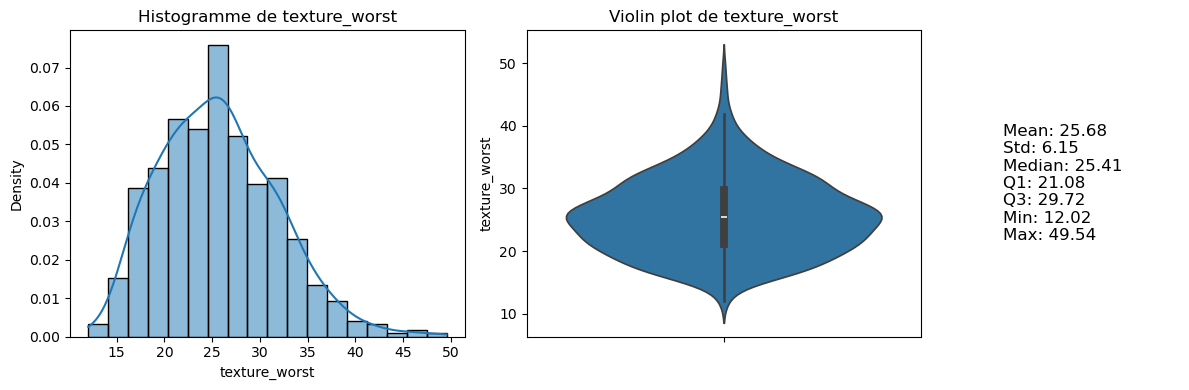

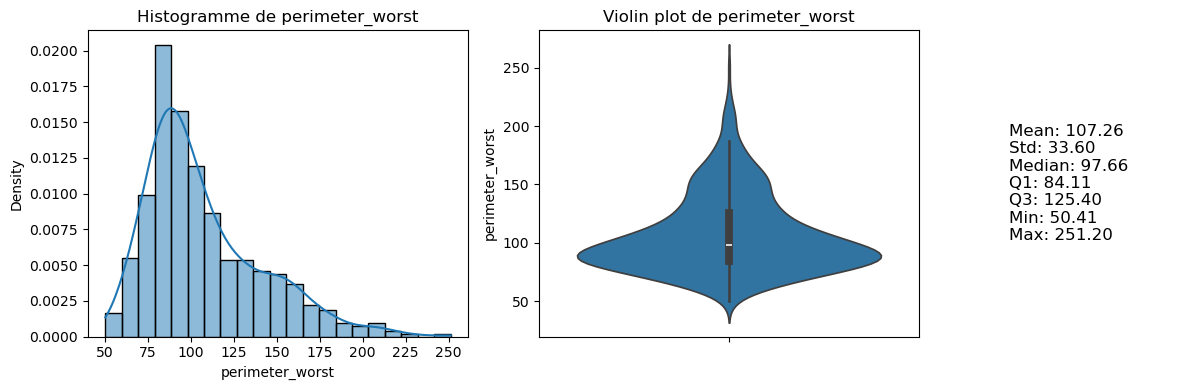

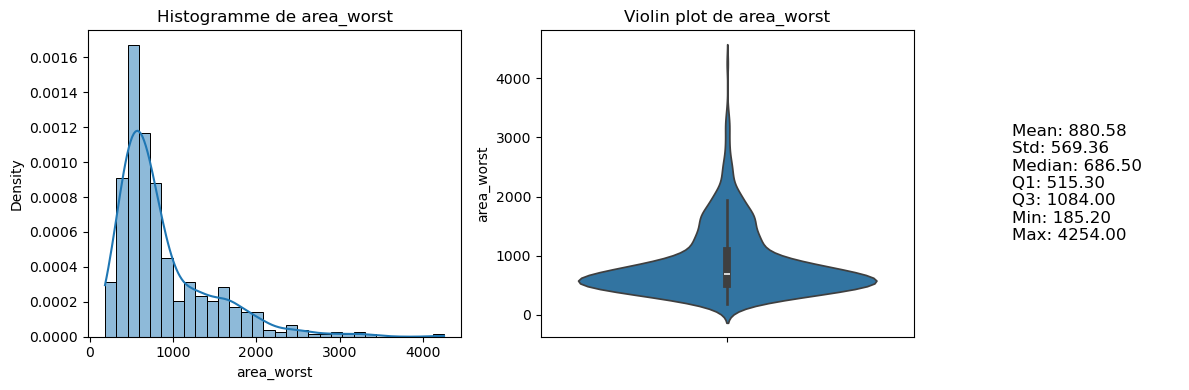

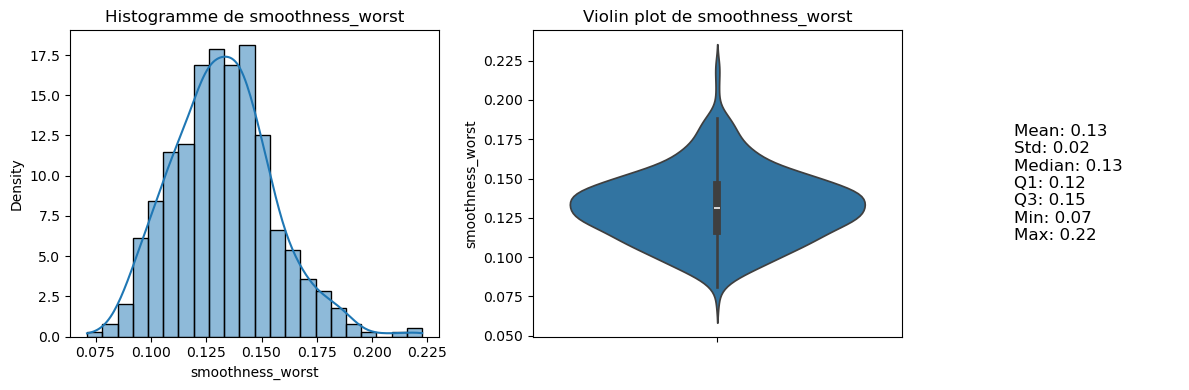

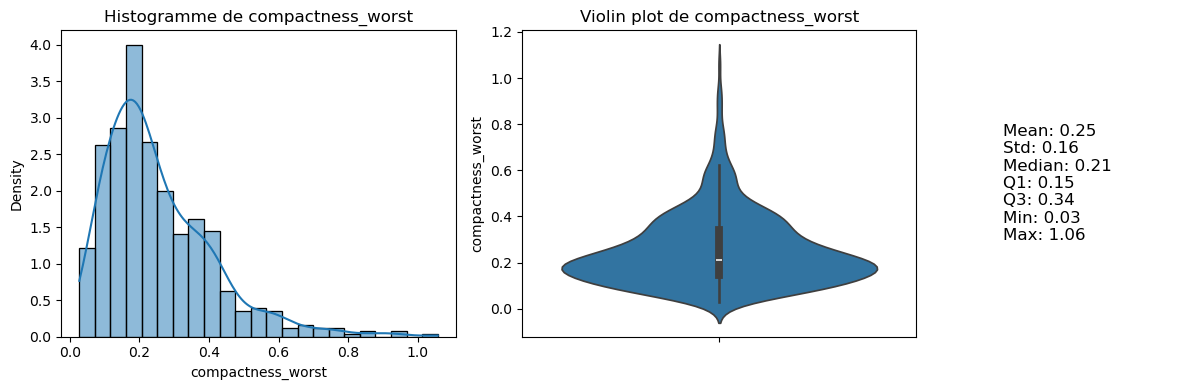

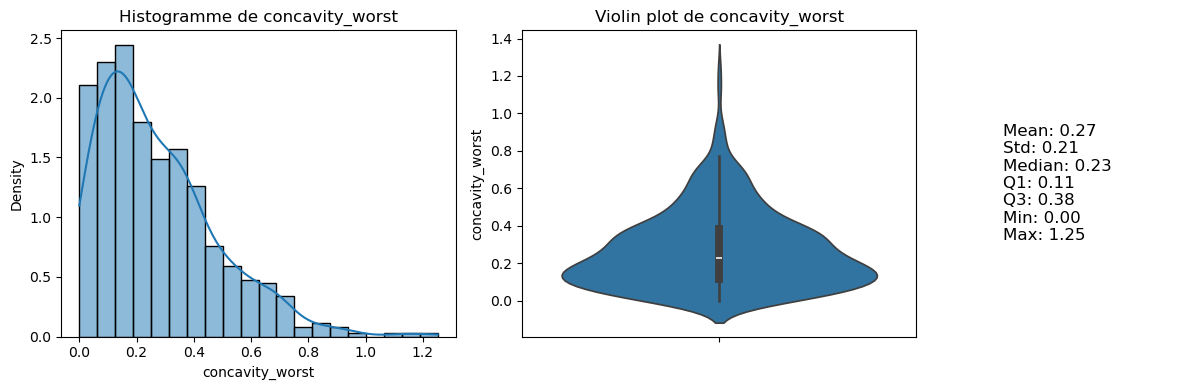

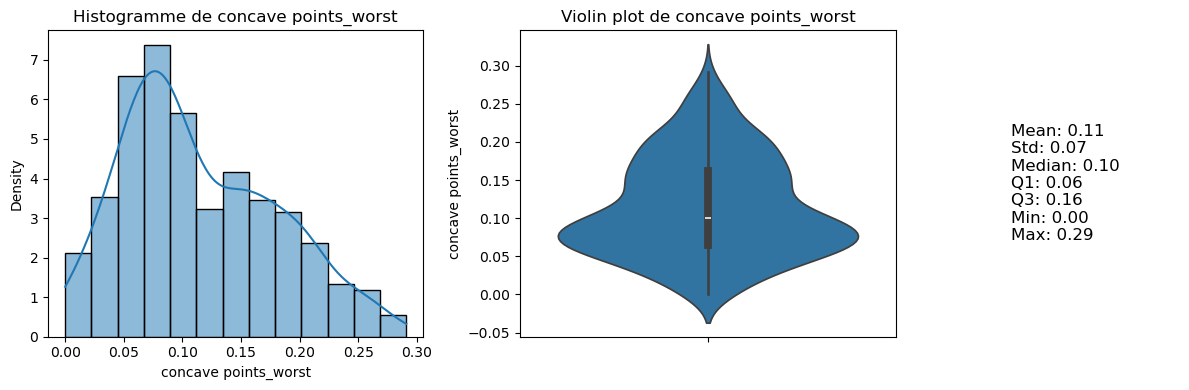

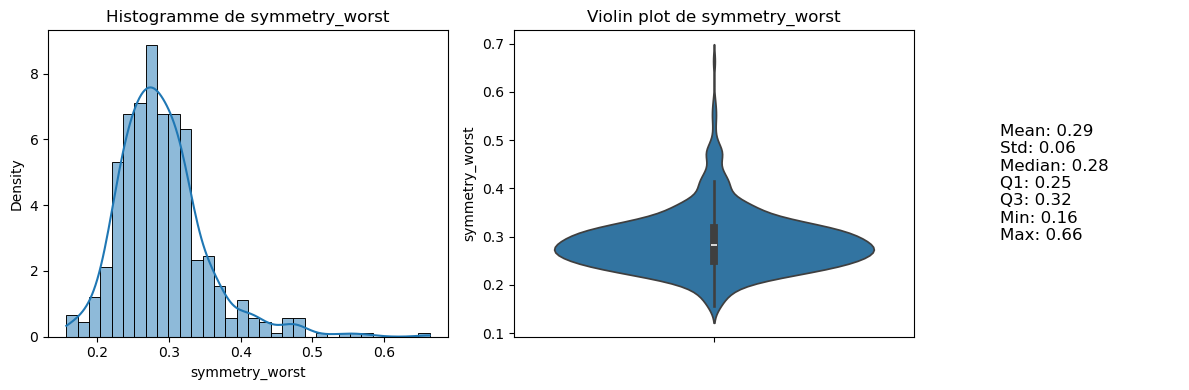

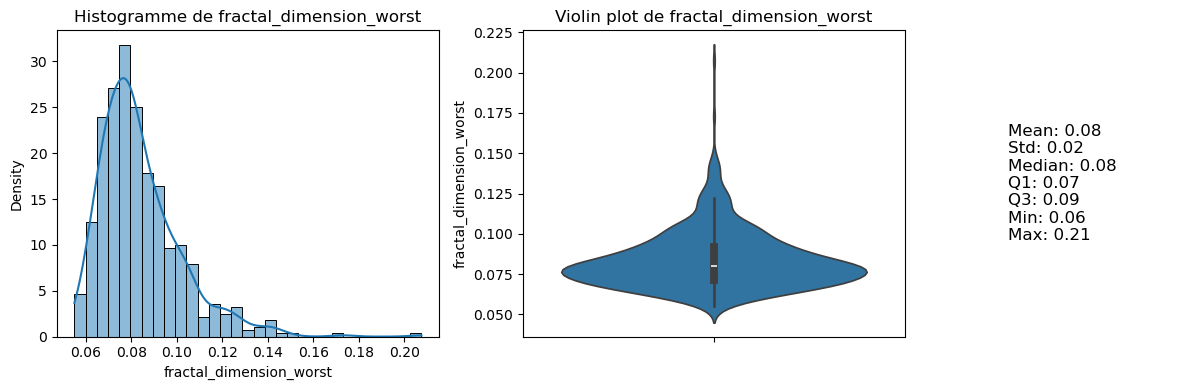

In [183]:
def plot_feature(df, col):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 2, 1]})

    # Histogramme avec KDE
    sns.histplot(df[col], kde=True, stat="density", ax=axes[0])
    axes[0].set_title(f"Histogramme de {col}")

    # Violin plot
    sns.violinplot(y=df[col], ax=axes[1])
    axes[1].set_title(f"Violin plot de {col}")

    # Calcul des statistiques
    stats = df[col].describe(percentiles=[0.25, 0.5, 0.75])
    textstr = f"""Mean: {stats['mean']:.2f}
Std: {stats['std']:.2f}
Median: {stats['50%']:.2f}
Q1: {stats['25%']:.2f}
Q3: {stats['75%']:.2f}
Min: {stats['min']:.2f}
Max: {stats['max']:.2f}"""

    # Ajouter les stats sous forme de texte
    axes[2].text(0.1, 0.5, textstr, fontsize=12, verticalalignment='center', transform=axes[2].transAxes)
    axes[2].axis("off")  # Supprimer les axes inutiles

    fig.tight_layout()

for col in df.select_dtypes('float'):
    plot_feature(df, col)


The values are not normalized. For the prediction, we need to normalize them.

## 2. Data Preprocessing

In [184]:
X = df[df.columns[3:]]
y = df['diagnosis']

# Transform Target to real value
code = {'M' : 1,
        'B' : 0}
y = y.map(code)
y.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [185]:
train_ratio = 0.8
# validation_ratio = 0.15
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(x_train.shape, y_train.shape,  x_test.shape)

(455, 28) (455,) (114, 28)


## 3. Training of Machine Learning Models

### 3.1 Random Forest Classifier


In [186]:
# Save results for each models
models_results = {}

In [187]:
numerical_features = make_column_selector(dtype_include=np.number)
numerical_pipeline = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

model = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42)
)

params = {
    'randomforestclassifier__n_estimators': range(10, 160, 5),
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [True, False],
}

grid=GridSearchCV(model, param_grid=params, scoring='recall', cv=5)

In [188]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x731d61d80550>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'randomforestclassifier__n_estimators': range(10, 160, 5)},
             scoring='recall')

In [189]:
print(grid.best_params_, grid.best_score_)

random_forest_model = grid.best_estimator_
print(random_forest_model)

{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 15} 0.9525846702317292
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x731d52e77ed0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, n_estimators=15,
                                        random_state=42))])


In [190]:
y_pred = random_forest_model.predict(x_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



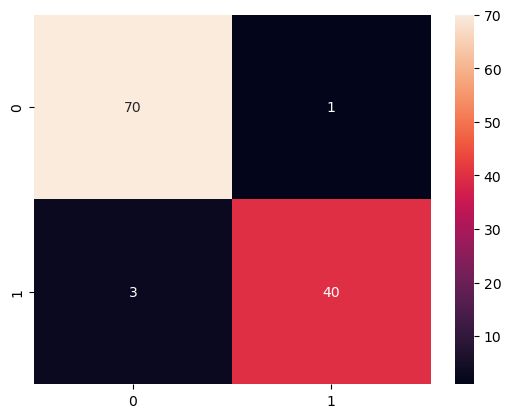

In [191]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.plot()

print(classification_report(y_test, y_pred))
models_results['RandomForestClassifier'] = classification_report(y_test, y_pred, output_dict=True)


### 3.2. SGD Classifier

In [192]:
numerical_features = make_column_selector(dtype_include=np.number)
numerical_pipeline = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

model = make_pipeline(
    preprocessor,
    SGDClassifier()
)

params = {
    'sgdclassifier__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'sgdclassifier__penalty': ['l1', 'l2', 'elacticnet'],
}

grid=GridSearchCV(model, param_grid=params, scoring='recall', cv=5)

In [193]:
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_)

sgd_model = grid.best_estimator_
print(sgd_model)

{'sgdclassifier__loss': 'log_loss', 'sgdclassifier__penalty': 'l1'} 0.9647058823529413
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x731d609716d0>)])),
                ('sgdclassifier',
                 SGDClassifier(loss='log_loss', penalty='l1'))])


/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.91      0.98      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



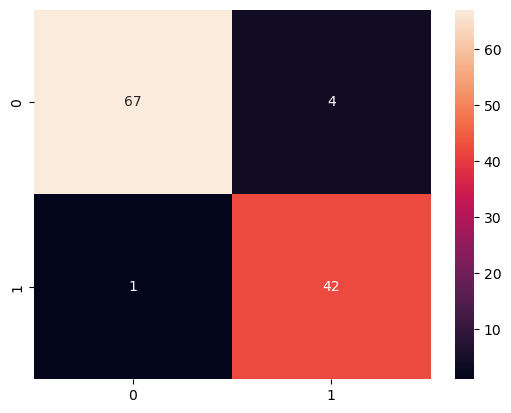

In [194]:
y_pred = sgd_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.plot()
print(classification_report(y_test, y_pred))
models_results['SGDClassifier'] = classification_report(y_test, y_pred, output_dict=True)

### 3.3 Linear SVC

In [195]:
numerical_features = make_column_selector(dtype_include=np.number)
numerical_pipeline = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

model = make_pipeline(
    preprocessor,
    svm.LinearSVC()
)

params = {
    'linearsvc__loss': ['hinge','squared_hinge'],
    'linearsvc__penalty': ['l1', 'l2'],
    'linearsvc__class_weight': [None, 'balanced']
}

grid=GridSearchCV(model, param_grid=params, scoring='recall', cv=5)

In [196]:
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_)

linear_svc_model = grid.best_estimator_
print(linear_svc_model)

/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'linearsvc__class_weight': None, 'linearsvc__loss': 'hinge', 'linearsvc__penalty': 'l2'} 0.9647058823529413
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x731d627f0550>)])),
                ('linearsvc', LinearSVC(loss='hinge'))])


/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



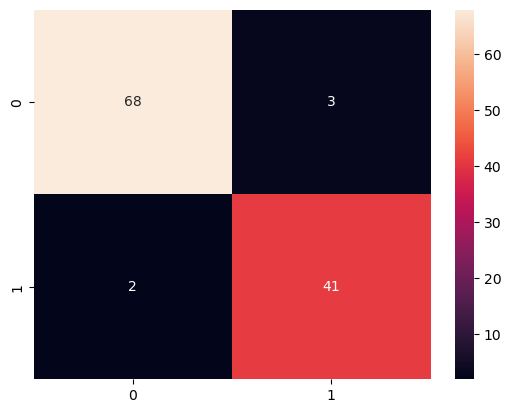

In [197]:
y_pred = linear_svc_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.plot()

print(classification_report(y_test, y_pred))
models_results['LinearSVC'] = classification_report(y_test, y_pred, output_dict=True)

### 3.4. K Neighbors Classifier

In [198]:
numerical_features = make_column_selector(dtype_include=np.number)
numerical_pipeline = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

model = make_pipeline(
    preprocessor,
    KNeighborsClassifier()
)

params = {
    'kneighborsclassifier__n_neighbors': range(10, 160, 5),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tre', 'kdtree' 'brute'],
}

grid=GridSearchCV(model, param_grid=params, scoring='recall', cv=5)

In [199]:
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_)

k_neighbors_model = grid.best_estimator_
print(k_neighbors_model)

{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'} 0.9053475935828876
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x731d50f72f50>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=10, weights='distance'))])


/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
600 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        71
           1       0.93      0.91      0.92        43

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



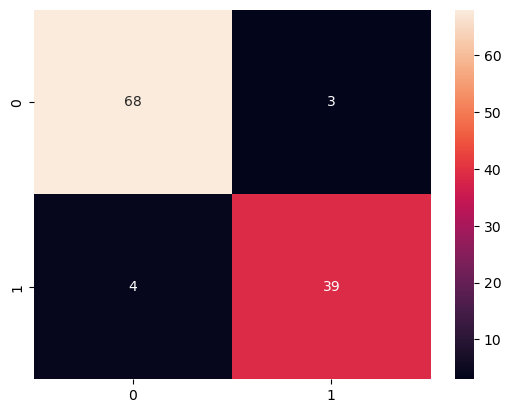

In [200]:
y_pred = k_neighbors_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.plot()

print(classification_report(y_test, y_pred))
models_results['KNeighborsClassifier'] = classification_report(y_test, y_pred, output_dict=True)

### 3.5. SVC

In [201]:
numerical_features = make_column_selector(dtype_include=np.number)
numerical_pipeline = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

model = make_pipeline(
    preprocessor,
    svm.SVC()
)

params = {
    'svc__kernel': ['linear','poly', 'rbf', 'sigmoid', 'precomputed'],
    'svc__class_weight': [None, 'balanced'],
    'svc__degree': range(1,11,1)
}

grid=GridSearchCV(model, param_grid=params, scoring='recall', cv=5)

In [202]:
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_)

svc_model = grid.best_estimator_
print(svc_model)

{'svc__class_weight': None, 'svc__degree': 1, 'svc__kernel': 'linear'} 0.9647058823529413
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x731d50b49590>)])),
                ('svc', SVC(degree=1, kernel='linear'))])


/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/e21g017n/miniconda3/envs/breast_cancer_prediction_project/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



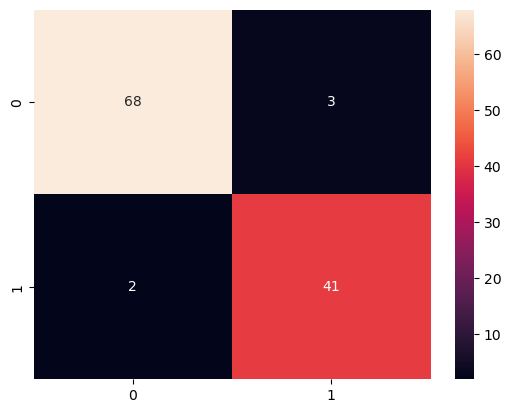

In [203]:
y_pred = svc_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.plot()

print(classification_report(y_test, y_pred))
models_results['SVC'] = classification_report(y_test, y_pred, output_dict=True)

### 3.6. Conclusion on Machine Learning models

Given this we want to predict as much as possible the patient with the cancer, we choose to **optimize our models based on the recall metric**. In fact, we want to minimize the false negative and maximize the identification of positive, either by identifying false positive. Do more clinical exams to finally identify the false positive is less critical than miss a positive patient. 

Let's have a look to this metric for the 5 learned models.

In [204]:
for model, stats_ in models_results.items():
    print(f"{model}\n\tRecall  : {stats_['weighted avg']['recall']}\n\tAccuracy: {stats_['accuracy']}")

RandomForestClassifier
	Recall  : 0.9649122807017544
	Accuracy: 0.9649122807017544
SGDClassifier
	Recall  : 0.956140350877193
	Accuracy: 0.956140350877193
LinearSVC
	Recall  : 0.956140350877193
	Accuracy: 0.956140350877193
KNeighborsClassifier
	Recall  : 0.9385964912280702
	Accuracy: 0.9385964912280702
SVC
	Recall  : 0.956140350877193
	Accuracy: 0.956140350877193


Based on these results the model with the best accuracy and recall is Random Forest. The recall and the accuracy are both equal to 0.96%, that is reasonable for the task we want. However, when we look more in details to the confusion matrix, we can observe that 3 cancer patients are not detected. This is a critical point. The most important is to detect the most as possible cancer patient, either identify false negative, which can be well classified later. With this point of view, **SGD model better identify cancer patient** (miss only 1 patient). While the accuracy and the global recall are lesser, **we select SGD model as the best model**. Now, the question is which feature are the most important in the model? On which biological data we need to principally focus.





In [205]:
sgd = sgd_model.named_steps["sgdclassifier"]
feature_importances = np.abs(sgd.coef_).flatten()
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df.head(10))

                 Feature  Importance
8              radius_se   61.048835
26        symmetry_worst   54.644736
11               area_se   36.735699
19         texture_worst   36.399722
24       concavity_worst   31.973475
3       compactness_mean   31.843092
6          symmetry_mean   30.125383
5    concave points_mean   28.816370
25  concave points_worst   28.067075
10          perimeter_se   20.986417


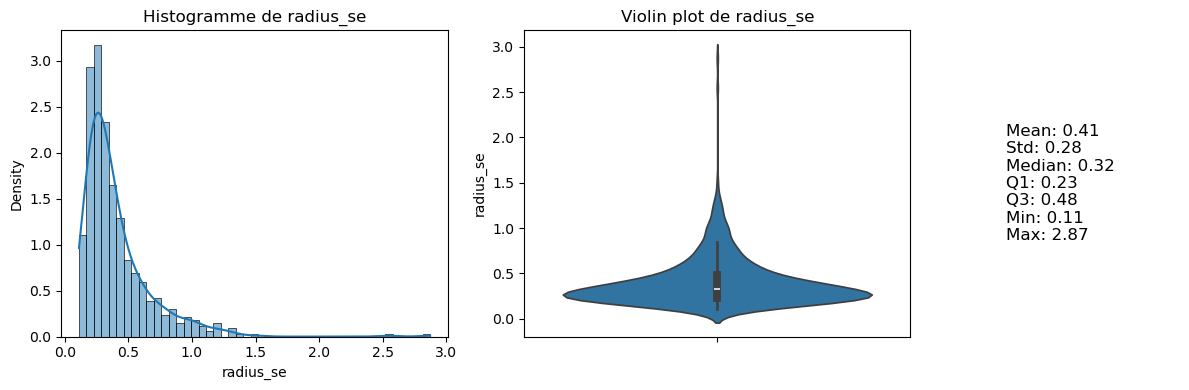

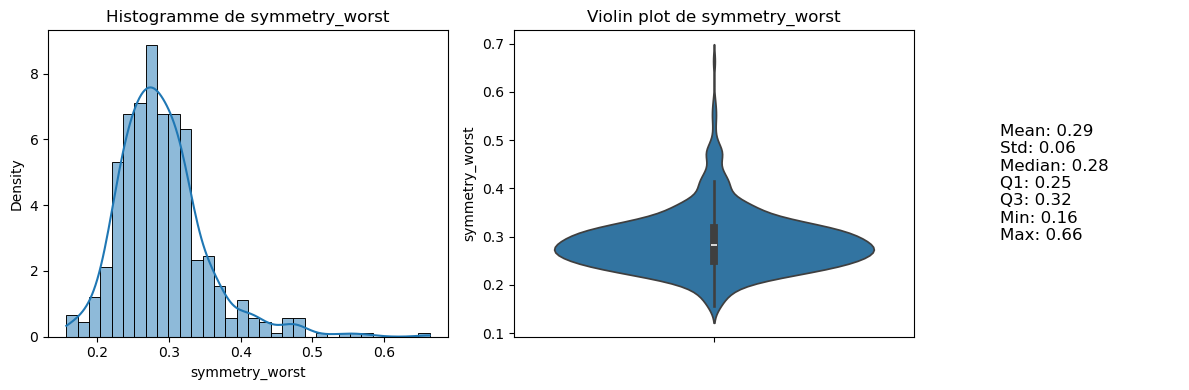

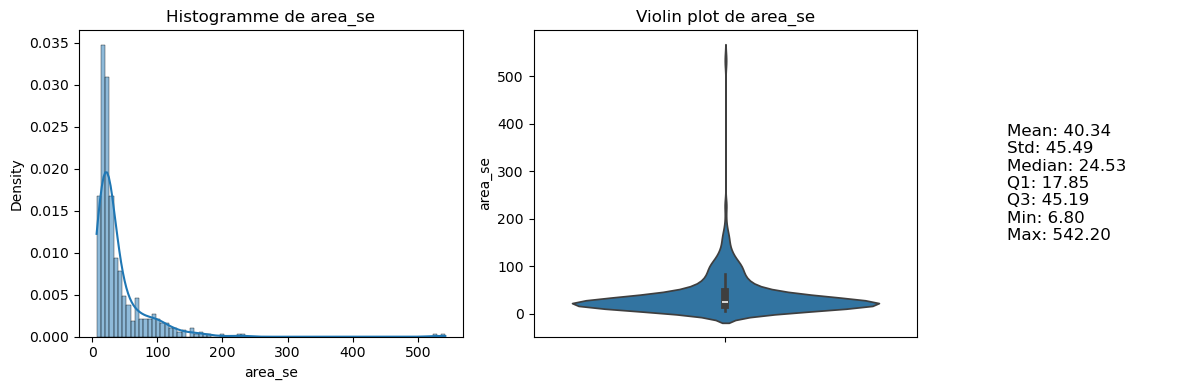

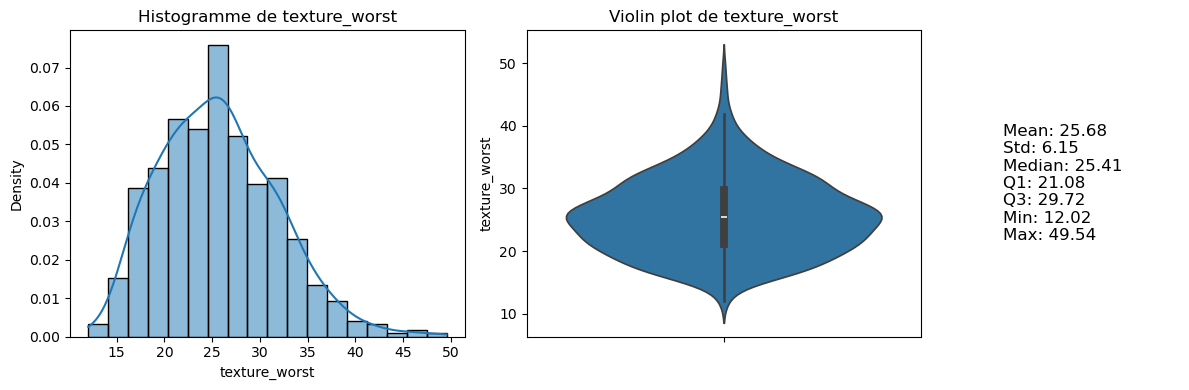

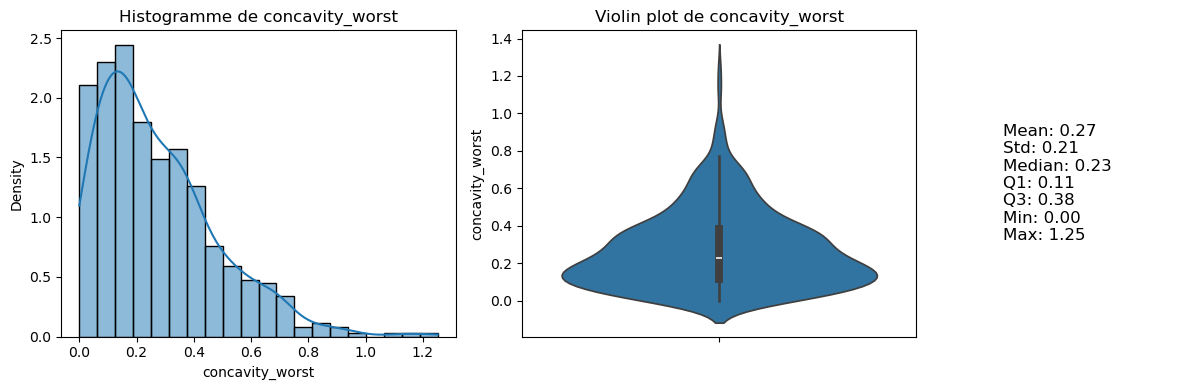

In [206]:
i = 1
for feature in feature_importance_df['Feature']:
    plot_feature(df, feature)
    if i==5:
        break
    else:
        i+=1

The most important biological characteristic is the standard error of the radius (radius_se). The second concerns the symmetry. The 3 next features also concerns the cell structure and its form. That makes sense because cancer cell does not have the same structure as healthy cells, in terms of size and shape, influencing the cell radius. In addition, the texture of cancer and healthy are not the same in terms of visualization. We can observe that cancer cells are darker than healthy ones. Finally, in general, cancer cells have not circular shape but contains concave regions. Thus, the fact that these characteristic grow up in the model make lot of sense.

If we come back to the confusion matrix of the SGD model, we observe 1 patient which their cancer is not detected. That can be critical especially in the medical context. In the future, improvements should be added to this work and try to reduce this value to zero.

Now, let's move to deep learning models and observe how they handle the problem to solve.

radius_se   61.048835
26        symmetry_worst   54.644736
11               area_se   36.735699
19         texture_worst   36.399722
24       concavity_worst 


## 4. Training Deep Learning Model

### 4.1. Training -- Keras model

In [207]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [208]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
print(torch.__version__)

Using cpu device
2.6.0+cu124


In [209]:
# Standardize the data. Same standardization as before.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [210]:
# Format data for keras input
x_train_np = x_train_scaled
y_train_np = y_train.to_numpy(dtype=np.float32)
x_test_np = x_test_scaled
y_test_np = y_test.to_numpy(dtype=np.float32)

print(x_train_np.shape)
print(y_train_np.shape)
print(type(y_train_np))

(455, 28)
(455,)
<class 'numpy.ndarray'>


In [211]:
# Neural network parameters
input_shape = x_train_np.shape[1]
hidden1     = 64
hidden2     = 32
hidden3     = 16

# Definition of the model
model = keras.Sequential([
    keras.layers.Input((input_shape,)),
    keras.layers.Dense( hidden1, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense( hidden2, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense( hidden3, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense( 1,      activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'recall'])

In [212]:
# Training the model
epochs = 150
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model_keras.keras"

# Save the best model encountered during training
savemodel_callback = keras.callbacks.ModelCheckpoint( filepath=save_dir, monitor='val_recall', mode='max', save_best_only=True)

history = model.fit(  x_train_np, y_train,
                      epochs          = epochs,
                      validation_data = (x_test_np, y_test),
                      callbacks=[savemodel_callback])

Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6380 - loss: 0.6406 - recall: 0.6288 - val_accuracy: 0.8246 - val_loss: 0.5730 - val_recall: 0.7442
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6595 - loss: 0.6250 - recall: 0.5945 - val_accuracy: 0.8684 - val_loss: 0.5451 - val_recall: 0.7674
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6639 - loss: 0.6188 - recall: 0.5621 - val_accuracy: 0.8860 - val_loss: 0.5206 - val_recall: 0.7674
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7111 - loss: 0.5802 - recall: 0.5441 - val_accuracy: 0.9035 - val_loss: 0.4978 - val_recall: 0.7907
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7236 - loss: 0.5686 - recall: 0.6412 - val_accuracy: 0.9123 - val_loss: 0.4757 - val_recall: 0.7907
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7301 - loss: 0.5631 - recall: 0.6178 - val_accuracy: 0.9211 - val_loss: 0.4557 - val_recall: 0.8140
Epoch 7/15

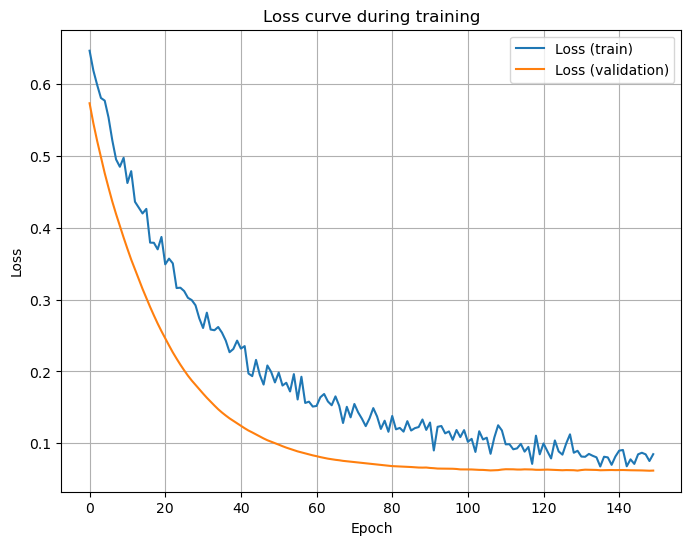

In [213]:
# Plot the Loss curve evolution during the training step
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss curve during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9701 - loss: 0.0877 - recall: 0.9586
Test loss     : 0.062059175223112106
Test accuracy : 0.9824561476707458
Test recall : 0.9767441749572754
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[]

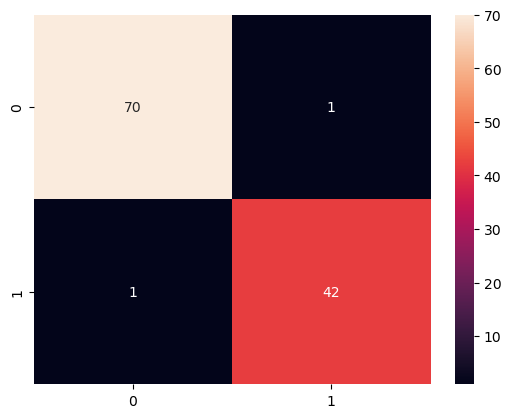

In [214]:
# Evaluate the last obtained model with test data
score = model.evaluate(x_test_np, y_test_np)

print('Test loss     :', score[0])
print('Test accuracy :', score[1])
print('Test recall :', score[2])
y_pred_proba = model.predict(x_test_np)

y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test_np, y_pred)

sns.heatmap(cm, annot=True)
plt.plot()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,445 (52.52 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,964 (35.02 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.1028 - recall: 0.9586
Test loss     : 0.08876430243253708
Test accuracy : 0.9824561476707458
Test recall : 0.9767441749572754
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[]

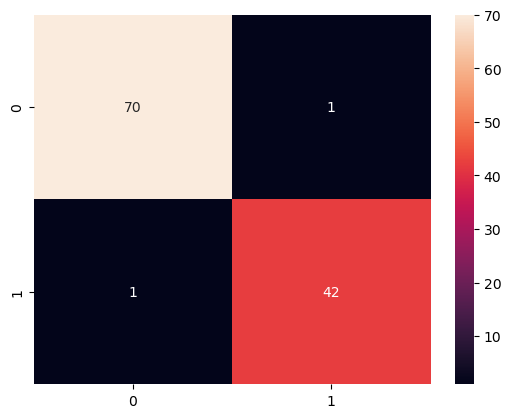

In [215]:
# Evaluate the best model with test data
loaded_model = keras.models.load_model('./run/models/best_model.keras')
loaded_model.summary()

score = loaded_model.evaluate(x_test_np, y_test_np)

print('Test loss     :', score[0])
print('Test accuracy :', score[1])
print('Test recall :', score[2])
y_pred_proba = loaded_model.predict(x_test_np)

y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test_np, y_pred)

sns.heatmap(cm, annot=True)
plt.plot()

### 4.2. Training -- PyTorch model

In [216]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable


In [217]:
X_train_tensor = torch.tensor(x_train_np, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_np, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

In [218]:
# Neural network parameters
input_shape = x_train_np.shape[1]


class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        hidden1     = 64
        hidden2     = 32
        hidden3     = 16
        self.hidden1 = nn.Linear(input_shape, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.hidden3 = nn.Linear(hidden2, hidden3)
        self.output = nn.Linear(hidden3, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = F.relu(self.hidden3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x



In [219]:
def fit(model, X_train, Y_train, X_test, Y_test, EPOCHS=5, BATCH_SIZE=32, save_path="./run/models/best_model_torch.pth"):
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    history = {
        "loss": [],
        "accuracy": [],
        "recall": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_recall": [],
    }

    best_val_recall = 0

    model.train()

    n = X_train.shape[0]
    for epoch in range(EPOCHS):
        batch_start = 0
        epoch_suffler = np.arange(n)
        np.random.shuffle(epoch_suffler)

        epoch_loss = 0
        correct = 0
        total = 0
        total_TP = 0
        total_FN = 0

        while batch_start + BATCH_SIZE < n:
            mini_batch_observations = epoch_suffler[batch_start:batch_start+BATCH_SIZE]
            var_X_batch = Variable(X_train[mini_batch_observations,:])
            var_Y_batch = Variable(Y_train[mini_batch_observations])

            optimizer.zero_grad()
            Y_pred_batch = model(var_X_batch).squeeze()

            curr_loss = loss_fn(Y_pred_batch, var_Y_batch)
            curr_loss.backward()
            optimizer.step()
            
            epoch_loss += curr_loss.item()

            predicted = (Y_pred_batch >= 0.5).float()
            correct += (predicted == var_Y_batch).sum().item()
            total += var_Y_batch.size(0)

            TP = ((predicted == 1) & (var_Y_batch == 1)).sum().item()
            FN = ((predicted == 0) & (var_Y_batch == 1)).sum().item()

            total_TP += TP
            total_FN += FN

            batch_start += BATCH_SIZE

        train_loss = epoch_loss / (n // BATCH_SIZE)
        train_acc = correct / total
        train_recall = total_TP / (total_TP + total_FN + 1e-8) # + 1e-8 to avoid div by zero error

        # Test set evaluation
        model.eval()
        with torch.no_grad():
            Y_pred_test = model(X_test).squeeze()
            val_loss = loss_fn(Y_pred_test, Y_test).item()
            predicted_test = (Y_pred_test >= 0.5).float()
            val_acc = (predicted_test == Y_test).sum().item() / Y_test.size(0)

            TP_test = ((predicted_test == 1) & (Y_test == 1)).sum().item()
            FN_test = ((predicted_test == 0) & (Y_test == 1)).sum().item()
            val_recall = TP_test / (TP_test + FN_test + 1e-8)

        model.train()
        
        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)
        history["recall"].append(train_recall)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["val_recall"].append(val_recall)

        if val_recall > best_val_recall:
            best_val_recall = val_recall
            torch.save(model.state_dict(), save_path)


        print(f"Epoch {epoch+1}/{EPOCHS} - "
              f"Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Recall: {train_recall:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Recall: {val_recall:.4f}")
        
    return history


In [220]:
# Training the model
epochs = 150

model = NeuralNetwork(input_shape=input_shape)
print(model)

history = fit(model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, EPOCHS=epochs)

NeuralNetwork(
  (hidden1): Linear(in_features=28, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch 1/150 - Loss: 0.7209, Accuracy: 0.3705, Recall: 1.0000, Val Loss: 0.7169, Val Accuracy: 0.3772, Val Recall: 1.0000
Epoch 2/150 - Loss: 0.7164, Accuracy: 0.3728, Recall: 1.0000, Val Loss: 0.7127, Val Accuracy: 0.3772, Val Recall: 1.0000
Epoch 3/150 - Loss: 0.7141, Accuracy: 0.3683, Recall: 1.0000, Val Loss: 0.7086, Val Accuracy: 0.3772, Val Recall: 1.0000
Epoch 4/150 - Loss: 0.7144, Accuracy: 0.3661, Recall: 1.0000, Val Loss: 0.7047, Val Accuracy: 0.3772, Val Recall: 1.0000
Epoch 5/150 - Loss: 0.7054, Accuracy: 0.3683, Recall: 1.0000, Val Loss: 0.7006, Val Accuracy: 0.3772, Val Recall: 1.0000
Epoch 6/150 - Loss: 0.7013, Accuracy: 0.3750, Recall: 1.0000, Val Loss: 0.6963, V

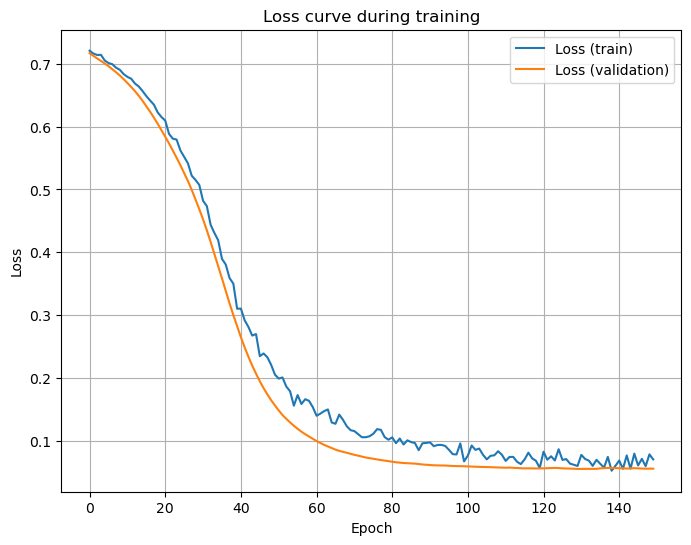

In [221]:
# Plot the Loss curve evolution during the training step
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Loss (train)')
plt.plot(history['val_loss'], label='Loss (validation)')
plt.title('Loss curve during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test Loss     : 0.0802
Test Accuracy : 0.9649
Test Recall   : 0.9767


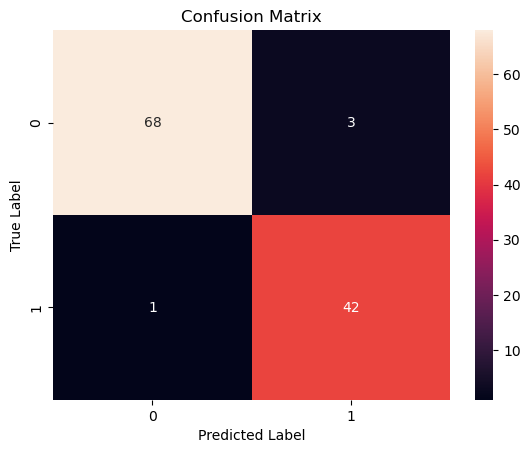

In [222]:
# Evaluate the last learned model

loss_fn = nn.BCELoss()

with torch.no_grad():
    Y_pred_proba = model(X_test_tensor).squeeze()  
    test_loss = loss_fn(Y_pred_proba, Y_test_tensor).item()
    
   
    Y_pred = (Y_pred_proba >= 0.5).float()
    
    correct = (Y_pred == Y_test_tensor).sum().item()
    accuracy = correct / Y_test_tensor.size(0)
    
    recall = ((Y_pred * Y_test_tensor).sum().item()) / (Y_test_tensor.sum().item() + 1e-8)  # Recall = TP / (TP + FN) -- 
    
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {accuracy:.4f}")
print(f"Test Recall   : {recall:.4f}")

cm = confusion_matrix(Y_test_tensor.numpy(), Y_pred.numpy())


sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Test Loss     : 0.7169
Test Accuracy : 0.3772
Test Recall   : 1.0000


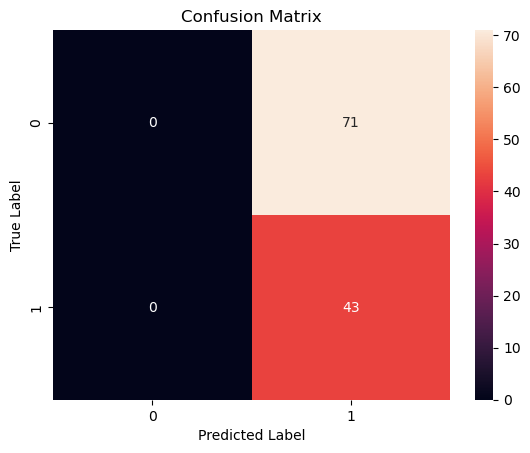

In [223]:
# Evaluate the best saved model

loss_fn = nn.BCELoss()
model = NeuralNetwork(input_shape=input_shape) 
model.load_state_dict(torch.load("./run/models/best_model_torch.pth"))
model.eval() 

with torch.no_grad():
    Y_pred_proba = model(X_test_tensor).squeeze()
    test_loss = loss_fn(Y_pred_proba, Y_test_tensor).item()
    
    Y_pred = (Y_pred_proba >= 0.5).float()
    
    correct = (Y_pred == Y_test_tensor).sum().item()
    accuracy = correct / Y_test_tensor.size(0)
    
    recall = ((Y_pred * Y_test_tensor).sum().item()) / (Y_test_tensor.sum().item() + 1e-8)  # Recall = TP / (TP + FN)
    
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {accuracy:.4f}")
print(f"Test Recall   : {recall:.4f}")

cm = confusion_matrix(Y_test_tensor.numpy(), Y_pred.numpy())


sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

###  4.3. Conclusion on Deep Learning model

We train the same deep neural network with two libraries (Keras and PyTorch). They are composed of 3 dense layers (64, 32 and 16 neurons) and a last layer with sigmoid activation function. The last function of the network is a binary cross entropy because we want to predict a binary class (malign or benign). Observing the Loss curve during the training we see that the validation loss tends to a plateau meaning a good learning. 

Let's have a look on the prediction made by the models learned during the training. 
For Keras models, we observe that the accuracy is about 97% and the recall about 98% - these results was obtained with the best saved model (with the highest recall value).
For PyTorch, the accuracy is also about 97% and the recall about 98%. Here, the best model (with the highest recall produces inaccurate results, saved at the beginning of training) so we use the last model of the training process.
The confusion matrices indicate that the model miss 1 cancer patient. This point is important to keep in mind! A healthy patient is classified as cancer patient. A further biological test will discover that the patient finally is healthy.  

To conclude a further improvement is needed to better identify cancer patient. 



## 5. General Conclusion

We explore training of multiple machine learning models and one deep learning model. Comparing the best ML model, SGD, with the DL model, DL model has higher accuracy and recall: 98% and 98% vs. 96% and 96%. Both models miss 1 cancer patient that is critical. SGD classify more healthy patient as cancer one (4 vs. 1).

Given this, the **Neural Network model is the best model** we train in this project, **with an accuracy of 98%**. It is important note that we need to improve this model because it still misses cancer patient that can be critical in medicine field. 


---

Author: Mathieu Bolteau

Website: [https://mathieubolteau.xyz/](https://mathieubolteau.xyz/)